In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(corrplot)
library(caret)
library(dplyr)
library(ggplot2)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
corrplot 0.92 loaded

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




[1] "customer-churn"

In [2]:
data <- read.csv("/kaggle/input/customer-churn/customer_churn.csv")
dim(data)
head(data)

[1] 900  10

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
1,Cameron Williams,42,11066.80,0,7.22,8,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
2,Kevin Mueller,41,11916.22,0,6.50,11,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 17756",Wilson PLC,1
3,Eric Lozano,38,12884.75,0,6.67,12,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
4,Phillip White,42,8010.76,0,6.71,10,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
5,Cynthia Norton,37,9191.58,0,5.56,9,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1
6,Jessica Williams,48,10356.02,0,5.12,8,2009-03-03 23:13:37,"6187 Olson Mountains East Vincentborough, PR 74359",Kelly-Warren,1


In [3]:
str(data)

'data.frame':	900 obs. of  10 variables:
 $ Names          : chr  "Cameron Williams" "Kevin Mueller" "Eric Lozano" "Phillip White" ...
 $ Age            : num  42 41 38 42 37 48 44 32 43 40 ...
 $ Total_Purchase : num  11067 11916 12885 8011 9192 ...
 $ Account_Manager: int  0 0 0 0 0 0 1 1 1 1 ...
 $ Years          : num  7.22 6.5 6.67 6.71 5.56 5.12 5.23 6.92 5.46 7.11 ...
 $ Num_Sites      : num  8 11 12 10 9 8 11 9 11 11 ...
 $ Onboard_date   : chr  "2013-08-30 07:00:40" "2013-08-13 00:38:46" "2016-06-29 06:20:07" "2014-04-22 12:43:12" ...
 $ Location       : chr  "10265 Elizabeth Mission Barkerburgh, AK 89518" "6157 Frank Gardens Suite 019 Carloshaven, RI 17756" "1331 Keith Court Alyssahaven, DE 90114" "13120 Daniel Mount Angelabury, WY 30645-4695" ...
 $ Company        : chr  "Harvey LLC" "Wilson PLC" "Miller, Johnson and Wallace" "Smith Inc" ...
 $ Churn          : int  1 1 1 1 1 1 1 1 1 1 ...


In [4]:
# Store Names, location columns as Person and place
Person <- data$Names
place <- data$Location

In [5]:
#convert string columns to factor
data$Account_Manager <- as.factor(data$Account_Manager)
data$Churn <- as.factor(data$Churn)

In [6]:
#calculate the difference between the onboard date column of the dataframe and the current date as a number of days using mutate() and the difftime() function
data <- data %>% 
mutate(
Onboard_date = as.Date(Onboard_date, "%Y-%m-%d %H:%M:%S"),
Current_date = Sys.Date(),
Days_difference = as.numeric(difftime(Current_date, Onboard_date, units = "days")))

In [7]:
# Remove the Names and Location columns
data$Names <- NULL
data$Location <- NULL
data$Onboard_date <- NULL
data$Current_date <- NULL
data$Company <- NULL

In [8]:
str(data)

'data.frame':	900 obs. of  7 variables:
 $ Age            : num  42 41 38 42 37 48 44 32 43 40 ...
 $ Total_Purchase : num  11067 11916 12885 8011 9192 ...
 $ Account_Manager: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 2 2 2 ...
 $ Years          : num  7.22 6.5 6.67 6.71 5.56 5.12 5.23 6.92 5.46 7.11 ...
 $ Num_Sites      : num  8 11 12 10 9 8 11 9 11 11 ...
 $ Churn          : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Days_difference: num  3770 3787 2736 3535 2898 ...


In [9]:
#check for missing values
sum(is.na(data))
any(is.na(data))

#check for duplicates
sum(duplicated(data))
any(duplicated(data))

[1] 0

[1] FALSE

[1] 0

[1] FALSE

In [10]:
# Creating correlation matrix for diamonds dataset
correlation_M <- cor(data[,c(1,2,4,5,7)])
print(correlation_M)

                         Age Total_Purchase        Years    Num_Sites
Age              1.000000000   -0.037208099  0.005625028 -0.006070481
Total_Purchase  -0.037208099    1.000000000 -0.005623171 -0.003390004
Years            0.005625028   -0.005623171  1.000000000  0.051641665
Num_Sites       -0.006070481   -0.003390004  0.051641665  1.000000000
Days_difference -0.002604292    0.020518726  0.044916504  0.031829276
                Days_difference
Age                -0.002604292
Total_Purchase      0.020518726
Years               0.044916504
Num_Sites           0.031829276
Days_difference     1.000000000


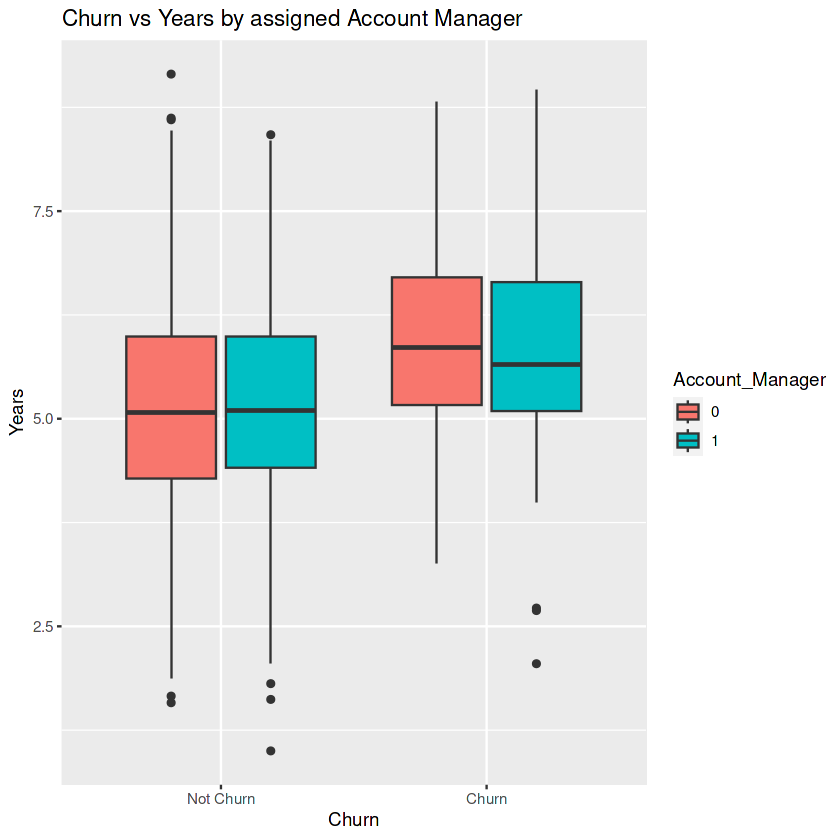

In [11]:
#churn and age
ggplot(data, aes(x = factor(Churn), y = Years, fill = Account_Manager)) +
    geom_boxplot() +
    scale_x_discrete(labels = c("Not Churn", "Churn")) +
    labs(x = "Churn", y = "Years", title = "Churn vs Years by assigned Account Manager") 


As you can see, customers who weren't get the Account Managers has a high probability to leave the company than customers who had Account Managers.

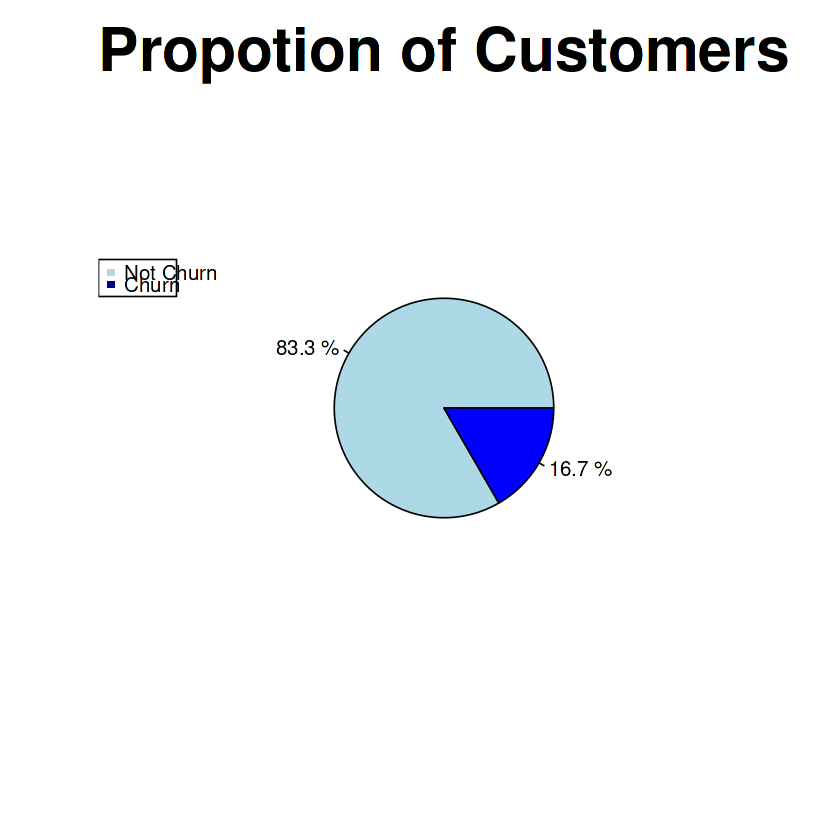

In [12]:
td <- table(data$Churn)

#td as percentages
rates <- paste(round(prop.table(td) * 100, 1), "%")

#plot a pie chart to show the proportion of churn and not churn
pie(td, labels = rates, main = "Propotion of Customers", col = c("Light Blue", "Blue"), clockwise = FALSE, cex.main = 3)
legend("topleft", c("Not Churn", "Churn"), cex = 1 ,fill = c("Light blue", " Dark Blue"), border = NA)

In [13]:
#check weather the churn has a relationship with Account_manager col
xtabs(~Churn + data$Account_Manager, data = data)

     data$Account_Manager
Churn   0   1
    0 401 349
    1  66  84

In [14]:
# Split the data into training and testing sets
set.seed(123)
trainIndex <- createDataPartition(data$Churn, p = 0.7, list = FALSE)
trainData <- data[trainIndex, ]
testData <- data[-trainIndex, ]

In [15]:
head(trainData)
head(testData)
str(trainData)
str(testData)

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn,Days_difference
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
1,42,11066.80,0,7.22,8,1,3770
2,41,11916.22,0,6.50,11,1,3787
3,38,12884.75,0,6.67,12,1,2736
4,42,8010.76,0,6.71,10,1,3535
5,37,9191.58,0,5.56,9,1,2898
6,48,10356.02,0,5.12,8,1,5411


,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn,Days_difference
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
13,45,8988.67,1,4.84,11,1,4696
16,38,10494.82,1,6.81,12,1,3079
17,45,8213.41,1,7.35,11,1,6323
21,41,9771.22,0,5.81,11,1,3862
22,56,12217.95,1,5.79,11,1,2595
26,54,8207.10,0,4.26,11,1,3187


'data.frame':	630 obs. of  7 variables:
 $ Age            : num  42 41 38 42 37 48 44 32 43 40 ...
 $ Total_Purchase : num  11067 11916 12885 8011 9192 ...
 $ Account_Manager: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 2 2 2 ...
 $ Years          : num  7.22 6.5 6.67 6.71 5.56 5.12 5.23 6.92 5.46 7.11 ...
 $ Num_Sites      : num  8 11 12 10 9 8 11 9 11 11 ...
 $ Churn          : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Days_difference: num  3770 3787 2736 3535 2898 ...
'data.frame':	270 obs. of  7 variables:
 $ Age            : num  45 38 45 41 56 54 35 37 44 38 ...
 $ Total_Purchase : num  8989 10495 8213 9771 12218 ...
 $ Account_Manager: Factor w/ 2 levels "0","1": 2 2 2 1 2 1 1 2 2 1 ...
 $ Years          : num  4.84 6.81 7.35 5.81 5.79 4.26 4.42 5.6 5.45 5.83 ...
 $ Num_Sites      : num  11 12 11 11 11 11 11 10 12 12 ...
 $ Churn          : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Days_difference: num  4696 3079 6323 3862 2595 ...


In [16]:
# Train a logistic regression model
model <- glm(Churn ~ trainData$Account_Manager, data = trainData, family = "binomial")
summary(model)


Call:
glm(formula = Churn ~ trainData$Account_Manager, family = "binomial", 
    data = trainData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6335  -0.6335  -0.5766  -0.5766   1.9372  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -1.7101     0.1522 -11.238   <2e-16 ***
trainData$Account_Manager1   0.2060     0.2140   0.963    0.336    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 567.71  on 629  degrees of freedom
Residual deviance: 566.78  on 628  degrees of freedom
AIC: 570.78

Number of Fisher Scoring iterations: 4


**Account Manager** column and **Churn** columns are not *statistically significant*.

In [17]:
# Train a logistic regression model considering all the variables
model2 <- glm(Churn ~ ., data = trainData, family = "binomial")
summary(model2)
#age is a significant variable
#Year is a significant variable
#Num_Sites is a significant variable


Call:
glm(formula = Churn ~ ., family = "binomial", data = trainData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3481  -0.4300  -0.2221  -0.0808   3.3921  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -1.950e+01  2.060e+00  -9.465  < 2e-16 ***
Age               8.661e-02  2.457e-02   3.525 0.000423 ***
Total_Purchase    4.591e-06  5.769e-05   0.080 0.936568    
Account_Manager1  3.517e-01  2.773e-01   1.268 0.204729    
Years             6.154e-01  1.113e-01   5.528 3.24e-08 ***
Num_Sites         1.111e+00  1.131e-01   9.819  < 2e-16 ***
Days_difference   1.648e-05  1.207e-04   0.136 0.891441    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 567.71  on 629  degrees of freedom
Residual deviance: 344.18  on 623  degrees of freedom
AIC: 358.18

Number of Fisher Scoring iterations: 6


In [18]:
#to plot the model, create new data frame
predicted <- data.frame(P.of.churn = model2$fitted.values, Churn = trainData$Churn)

In [19]:
#sort low to high
predicted <- predicted[order(predicted$P.of.churn, decreasing=FALSE),]

In [20]:
#add a column to rank the samples
predicted$rank <- 1:nrow(predicted)

Saving 12.5 x 6.67 in image


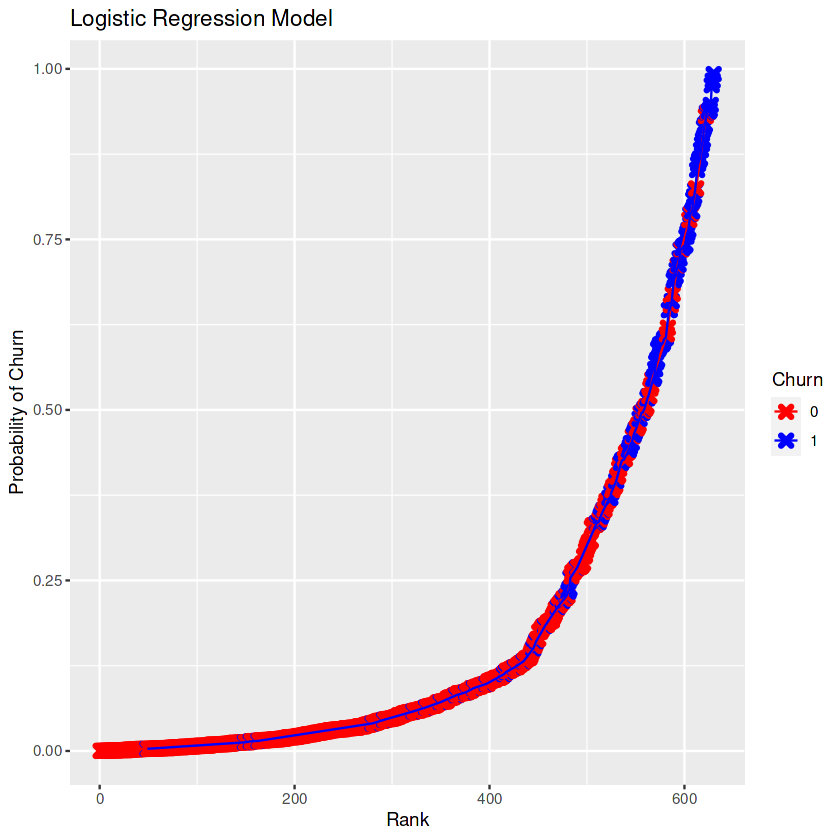

In [21]:
#plot using ggplot
ggplot(predicted, aes(x=rank, y=P.of.churn, color=Churn)) + 
geom_point(alpha=1, shape=4, stroke=2) + geom_line() + 
scale_color_manual(values=c("red", "blue")) + 
labs(x="Rank", y="Probability of Churn", title="Logistic Regression Model")

#save the graph
ggsave("F:/VisualStudio/LogisticRegressionModel2.png")

# **Apply the model to Test set**

In [22]:
# Predict the Churn values for the test data
predicted <- predict(model2, testData, type = "response")

# Convert probabilities to binary predictions (Churn or Stay)
predicted <- ifelse(predicted > 0.5, "Stay", "Churn")

#make the predicted labels and actual labels as factors
predicted <- as.factor(predicted)
testData$Churn <- as.factor(testData$Churn)

In [23]:
#plot the confusion matrix
# First, convert the predicted and testData$Churn to factors
predicted <- as.factor(predicted)
testData$Churn <- as.factor(testData$Churn)

# Ensure that the levels of predicted and testData$Churn match
levels(predicted) <- levels(testData$Churn)

# Now, create the confusion matrix
confusion_matrix <- table(testData$Churn, predicted)

# Create a confusion matrix plot
confusionMatrixPlot <- confusionMatrix(confusion_matrix)
confusionMatrixPlot

Confusion Matrix and Statistics

   predicted
      0   1
  0 218   7
  1  20  25
                                          
               Accuracy : 0.9             
                 95% CI : (0.8578, 0.9331)
    No Information Rate : 0.8815          
    P-Value [Acc > NIR] : 0.20024         
                                          
                  Kappa : 0.593           
                                          
 Mcnemar's Test P-Value : 0.02092         
                                          
            Sensitivity : 0.9160          
            Specificity : 0.7812          
         Pos Pred Value : 0.9689          
         Neg Pred Value : 0.5556          
             Prevalence : 0.8815          
         Detection Rate : 0.8074          
   Detection Prevalence : 0.8333          
      Balanced Accuracy : 0.8486          
                                          
       'Positive' Class : 0               
                                          

# **Evaluate the model**

In [24]:
# Calculate accuracy
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)

# Calculate sensitivity (true positive rate)
sensitivity <- confusion_matrix[2, 2] / sum(confusion_matrix[2, ])

# Calculate specificity (true negative rate)
specificity <- confusion_matrix[1, 1] / sum(confusion_matrix[1, ])

# Print the results
print(paste("Accuracy of the model is: ", accuracy))
print(paste("Sensitivity of the model is: ", sensitivity))
print(paste("Specificity of the model is: ",specificity))

[1] "Accuracy of the model is:  0.9"
[1] "Sensitivity of the model is:  0.555555555555556"
[1] "Specificity of the model is:  0.968888888888889"


Accuracy    = 90%
Sensitivity = 55.6%
Specificity = 96.8%


The model has a high accuracy but has relatively lower sensitivity. Depending on the nature of our problem, we want to investigate why sensitivity is low and whether it aligns with our goals. For some applications, a balance between sensitivity and specificity might be crucial, while in others, one metric might be more important than the other. It's often useful to consider the specific requirements and implications of *false positives* and *false negatives* in our particular use case.